In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

from tqdm.notebook import tqdm

from joblib import delayed, Parallel

import itertools

from sklearn.decomposition import PCA

In [17]:
df = pd.read_csv('./Video_games_esrb_rating.csv')
tag_columns = ['alcohol_reference', 'blood', 'suggestive_themes', 'violence']
X = df[tag_columns]
y = df['esrb_rating']

In [18]:
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)
X_pca_df = pd.DataFrame(X_pca, columns=['PC0', 'PC1'])

<Axes: xlabel='PC0', ylabel='PC1'>

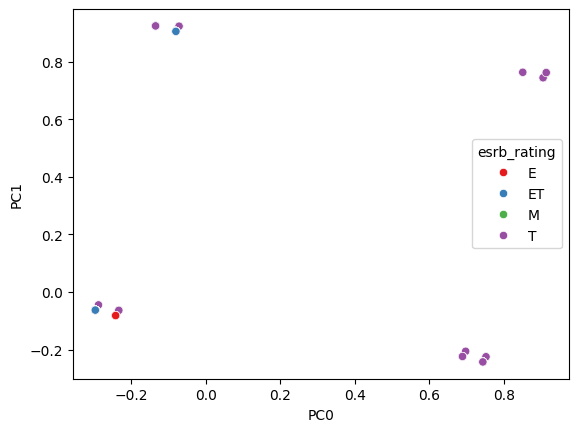

In [19]:
sns.set_palette('seismic')
sns.scatterplot(data=X_pca_df, x='PC0', y='PC1', hue=y, palette='Set1')

# Decision Tree com validação cruzada em dois níveis

In [20]:
k1 = 10 #controla o número de vias da validação cruzada para estimar o desempenho do modelo
k2 = 5 #controla o número de vida da validação cruzada para otimização de hiperparametros

#usar o protocolo de validação cruzada estratificada
skf = StratifiedKFold(n_splits=k1, shuffle=True, random_state=1)

conf_matrix = None

acuracias = []

#a função split retorna os índices das instâncias que devem ser usadas para o treinamento e o teste.
for idx_treino, idx_teste in skf.split(X, y):
    
    #extrair as instâncias de treinamento de acordo com os índices fornecidos pelo skf.split
    X_treino = X.iloc[idx_treino]
    y_treino = y.iloc[idx_treino]
    
    #extrair as instâncias de teste de acordo com os índices fornecidos pelo skf.split
    X_teste = X.iloc[idx_teste]
    y_teste = y.iloc[idx_teste]
    
    #colocar todas as variáveis na mesma escala, usando o conjunto de treinamento para calcular os parâmetros da escala
    ss = StandardScaler()
    ss.fit(X_treino)
    X_treino = ss.transform(X_treino)
    X_teste = ss.transform(X_teste)
    
    #combinações de parametros otimizar. Aqui estamos apenas otimizando o número de vizinhos mais próximos para o knn (k).
    #Entretanto, podemos colocar todos os valores de todos os parametros. O sklearn se encarrega de gerar todas as combinações.
    params = {
        'max_depth': [None, 2, 3, 4, 5],
        'min_samples_leaf': [1, 3, 5, 10, 15],
        'min_samples_split': [2, 4, 8, 16, 32]
    }
    #instanciar um KNN com parametros padrão
    dt = DecisionTreeClassifier()

    #instanciar um GridSearchCV com k2 vias.
    dt_classifier = GridSearchCV(dt, params, cv=StratifiedKFold(n_splits=k2), scoring='f1_weighted')
    
    #realizar a otimização dos hiperparâmetros e treinar o modelo final com a melhor combinação de hiperparametros com todos os dados de treinamento
    dt_classifier.fit(X_treino, y_treino)
    
    pred = dt_classifier.predict(X_teste)
    print(classification_report(y_teste, pred, zero_division=0))
    
    cm = confusion_matrix(y_teste, pred)
    if conf_matrix is None:
        conf_matrix = cm
    else:
        conf_matrix += cm

    
print("Soma das matrizes de confusão:")
print(conf_matrix)

              precision    recall  f1-score   support

           E       0.33      0.95      0.49        42
          ET       0.83      0.25      0.38        40
           M       0.00      0.00      0.00        39
           T       0.74      0.62      0.68        69

    accuracy                           0.49       190
   macro avg       0.48      0.46      0.39       190
weighted avg       0.52      0.49      0.44       190

              precision    recall  f1-score   support

           E       0.36      0.95      0.53        42
          ET       0.50      0.12      0.20        40
           M       0.00      0.00      0.00        39
           T       0.63      0.64      0.63        69

    accuracy                           0.47       190
   macro avg       0.37      0.43      0.34       190
weighted avg       0.41      0.47      0.39       190

              precision    recall  f1-score   support

           E       0.35      0.95      0.52        42
          ET       0.

# Treinando o modelo com os melhores parâmetros encontrados e plotando a árvore

Melhores parâmetros: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}


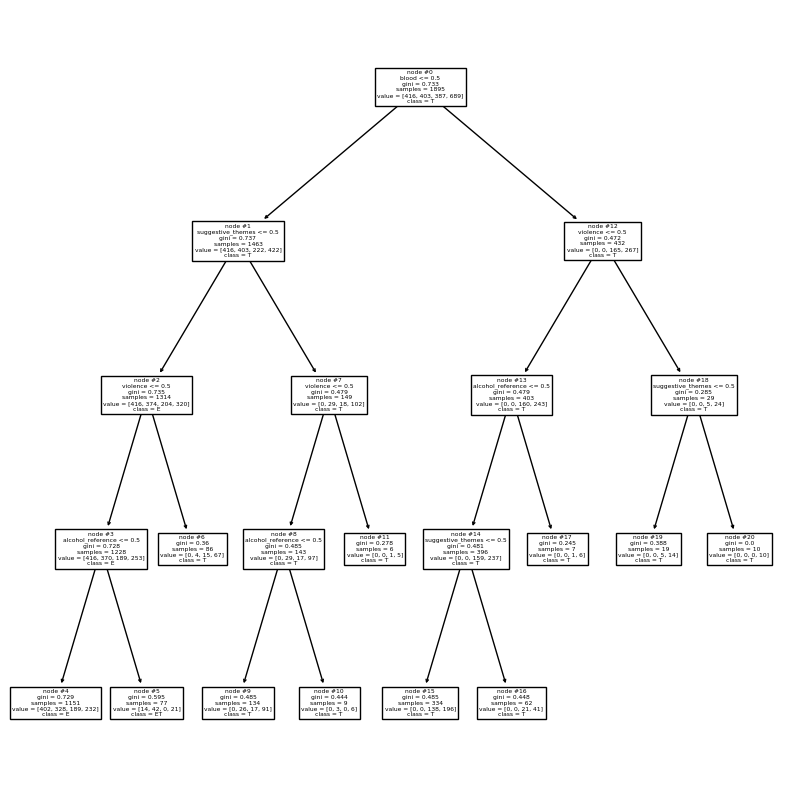

In [21]:
best_params = dt_classifier.best_params_ # melhores parâmetros

print("Melhores parâmetros:", best_params) # exibe os melhores parâmetros

dt = DecisionTreeClassifier(**best_params) # instanciando o modelo com os melhores parâmetros

dt.fit(X, y) # treinando o modelo com todos os dados

# plotando a árvore de decisão
plt.figure(figsize=(10,10))
plot_tree(dt, class_names=dt.classes_, feature_names=X.columns, node_ids=True)
plt.show()

## Exibindo a estrutura das regras da árvore de decisão

In [22]:
from sklearn.tree import _tree

In [23]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

get_rules(dt, X.columns.tolist(), dt.classes_)


['if (blood <= 0.5) and (suggestive_themes <= 0.5) and (violence <= 0.5) and (alcohol_reference <= 0.5) then class: E (proba: 34.93%) | based on 1,151 samples',
 'if (blood > 0.5) and (violence <= 0.5) and (alcohol_reference <= 0.5) and (suggestive_themes <= 0.5) then class: T (proba: 58.68%) | based on 334 samples',
 'if (blood <= 0.5) and (suggestive_themes > 0.5) and (violence <= 0.5) and (alcohol_reference <= 0.5) then class: T (proba: 67.91%) | based on 134 samples',
 'if (blood <= 0.5) and (suggestive_themes <= 0.5) and (violence > 0.5) then class: T (proba: 77.91%) | based on 86 samples',
 'if (blood <= 0.5) and (suggestive_themes <= 0.5) and (violence <= 0.5) and (alcohol_reference > 0.5) then class: ET (proba: 54.55%) | based on 77 samples',
 'if (blood > 0.5) and (violence <= 0.5) and (alcohol_reference <= 0.5) and (suggestive_themes > 0.5) then class: T (proba: 66.13%) | based on 62 samples',
 'if (blood > 0.5) and (violence > 0.5) and (suggestive_themes <= 0.5) then class: 

# Random Forest com validação cruzada em dois níveis

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
k1 = 10 #controla o número de vias da validação cruzada para estimar o desempenho do modelo
k2 = 5 #controla o número de vida da validação cruzada para otimização de hiperparametros

# usar o protocolo de validação cruzada estratificada
skf = StratifiedKFold(n_splits=k1, shuffle=True, random_state=1)

acuracias = []

# a função split retorna os índices das instâncias que devem ser usadas para o treinamento e o teste.
for idx_treino, idx_teste in skf.split(X, y):

    # extrair as instâncias de treinamento de acordo com os índices fornecidos pelo skf.split
    X_treino = X.iloc[idx_treino]
    y_treino = y.iloc[idx_treino]

    # extrair as instâncias de teste de acordo com os índices fornecidos pelo skf.split
    X_teste = X.iloc[idx_teste]
    y_teste = y.iloc[idx_teste]

    # colocar todas as variáveis na mesma escala, usando o conjunto de treinamento para calcular os parâmetros da escala
    ss = StandardScaler()
    ss.fit(X_treino)
    X_treino = ss.transform(X_treino)
    X_teste = ss.transform(X_teste)

    # combinações de parametros otimizar. Aqui estamos apenas otimizando o número de vizinhos mais próximos para o knn (k).
    # Entretanto, podemos colocar todos os valores de todos os parametros. O sklearn se encarrega de gerar todas as combinações.
    params={
        'criterion' : ['gini', 'entropy'], 
        'random_state' : [1], 
        'n_estimators': [100, 200, 500],
    }

    # instanciar um KNN com parametros padrão
    rf = RandomForestClassifier()

    # instanciar um GridSearchCV com k2 vias.
    rf = GridSearchCV(rf, params, cv=StratifiedKFold(n_splits=k2), scoring='f1_weighted')
    
    # realizar a otimização dos hiperparâmetros e treinar o modelo final com a melhor combinação de hiperparametros com todos os dados de treinamento
    rf.fit(X_treino, y_treino)

    # predizer os dados de teste usando o modelo treinado
    pred = rf.predict(X_teste)

    # calcular a acurácia do modelo na base de teste e imprimir
    print(classification_report(y_teste, pred))

    # calcular a matriz de confusão do modelo na base de teste e imprimir
    cm = confusion_matrix(y_teste, pred)
    if conf_matrix is None:
        conf_matrix = cm
    else:
        conf_matrix += cm

# imprimir a soma das matrizes de confusão
print("Soma das matrizes de confusão:")
print(conf_matrix)


c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           E       0.33      0.95      0.49        42
          ET       0.83      0.25      0.38        40
           M       0.00      0.00      0.00        39
           T       0.74      0.62      0.68        69

    accuracy                           0.49       190
   macro avg       0.48      0.46      0.39       190
weighted avg       0.52      0.49      0.44       190



c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           E       0.36      0.95      0.53        42
          ET       0.50      0.12      0.20        40
           M       0.00      0.00      0.00        39
           T       0.63      0.64      0.63        69

    accuracy                           0.47       190
   macro avg       0.37      0.43      0.34       190
weighted avg       0.41      0.47      0.39       190



c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           E       0.35      0.95      0.52        42
          ET       0.57      0.10      0.17        40
           M       0.00      0.00      0.00        39
           T       0.57      0.58      0.58        69

    accuracy                           0.44       190
   macro avg       0.37      0.41      0.32       190
weighted avg       0.41      0.44      0.36       190



c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           E       0.38      0.98      0.55        42
          ET       0.67      0.15      0.24        40
           M       0.00      0.00      0.00        39
           T       0.64      0.68      0.66        69

    accuracy                           0.49       190
   macro avg       0.42      0.45      0.36       190
weighted avg       0.46      0.49      0.41       190



KeyboardInterrupt: 

# KNN com validação cruzada em dois níveis

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [25]:
k1 = 10 #controla o número de vias da validação cruzada para estimar o desempenho do modelo
k2 = 5 #controla o número de vida da validação cruzada para otimização de hiperparametros

# usar o protocolo de validação cruzada estratificada
skf = StratifiedKFold(n_splits=k1, shuffle=True, random_state=1)

acuracias_met = []
acuracias = []

conf_matrix = None

# a função split retorna os índices das instâncias que devem ser usadas para o treinamento e o teste.
for idx_treino, idx_teste in skf.split(X, y):

    # extrair as instâncias de treinamento de acordo com os índices fornecidos pelo skf.split
    X_treino = X.iloc[idx_treino]
    y_treino = y.iloc[idx_treino]

    # extrair as instâncias de teste de acordo com os índices fornecidos pelo skf.split
    X_teste = X.iloc[idx_teste]
    y_teste = y.iloc[idx_teste]

    # colocar todas as variáveis na mesma escala, usando o conjunto de treinamento para calcular os parâmetros da escala
    ss = StandardScaler()
    ss.fit(X_treino)
    X_treino = ss.transform(X_treino)
    X_teste = ss.transform(X_teste)

    # combinações de parametros otimizar. Aqui estamos apenas otimizando o número de vizinhos mais próximos para o knn (k).
    # Entretanto, podemos colocar todos os valores de todos os parametros. O sklearn se encarrega de gerar todas as combinações.
    params = {'n_neighbors' : range(1,30,2)}

    # instanciar um KNN com parametros padrão
    knn = KNeighborsClassifier(metric='euclidean')

    # instanciar um GridSearchCV com k2 vias.
    knn = GridSearchCV(knn, params, cv=StratifiedKFold(n_splits=k2), scoring='f1_weighted')
    
    # realizar a otimização dos hiperparâmetros e treinar o modelo final com a melhor combinação de hiperparametros com todos os dados de treinamento
    knn.fit(X_treino, y_treino)

    pred = knn.predict(X_teste)
    # f1 = f1_score(y_teste, pred, average='weighted')
    # print("F1-Score:", f1)
    print(classification_report(y_teste, pred))

    cm = confusion_matrix(y_teste, pred)
    if conf_matrix is None:
        conf_matrix = cm
    else:
        conf_matrix += cm

print("Soma das matrizes de confusão:")
print(conf_matrix)


c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           E       0.33      0.95      0.49        42
          ET       0.83      0.25      0.38        40
           M       0.00      0.00      0.00        39
           T       0.74      0.62      0.68        69

    accuracy                           0.49       190
   macro avg       0.48      0.46      0.39       190
weighted avg       0.52      0.49      0.44       190

              precision    recall  f1-score   support

           E       0.36      0.95      0.53        42
          ET       0.50      0.12      0.20        40
           M       0.42      0.44      0.43        39
           T       0.70      0.30      0.42        69

    accuracy                           0.44       190
   macro avg       0.50      0.45      0.40       190
weighted avg       0.53      0.44      0.40       190

              precision    recall  f1-score   support

           E       0.35      0.95      0.52        42
          ET       0.

c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           E       0.00      0.00      0.00        41
          ET       0.33      0.07      0.12        41
           M       0.29      0.21      0.24        38
           T       0.29      0.64      0.40        69

    accuracy                           0.29       189
   macro avg       0.23      0.23      0.19       189
weighted avg       0.24      0.29      0.22       189

              precision    recall  f1-score   support

           E       0.34      0.95      0.50        41
          ET       0.29      0.10      0.15        40
           M       0.39      0.31      0.34        39
           T       0.67      0.29      0.40        69

    accuracy                           0.40       189
   macro avg       0.42      0.41      0.35       189
weighted avg       0.46      0.40      0.36       189

Soma das matrizes de confusão:
[[362  14   0  40]
 [291  43   0  69]
 [169   1 130  87]
 [216  27 173 273]]


# SVM com validação cruzada em dois níveis

In [28]:
from sklearn.svm import SVC

In [29]:
k1 = 10 #controla o número de vias da validação cruzada para estimar o desempenho do modelo
k2 = 5 #controla o número de vida da validação cruzada para otimização de hiperparametros

#usar o protocolo de validação cruzada estratificada
skf = StratifiedKFold(n_splits=k1, shuffle=True, random_state=1)

acuracias = []

#a função split retorna os índices das instâncias que devem ser usadas para o treinamento e o teste.
for idx_treino, idx_teste in skf.split(X, y):
    
    #extrair as instâncias de treinamento de acordo com os índices fornecidos pelo skf.split
    X_treino = X.iloc[idx_treino]
    y_treino = y.iloc[idx_treino]
    
    #extrair as instâncias de teste de acordo com os índices fornecidos pelo skf.split
    X_teste = X.iloc[idx_teste]
    y_teste = y.iloc[idx_teste]
    
    #colocar todas as variáveis na mesma escala, usando o conjunto de treinamento para calcular os parâmetros da escala
    ss = StandardScaler()
    ss.fit(X_treino)
    X_treino = ss.transform(X_treino)
    X_teste = ss.transform(X_teste)
    
    #combinações de parametros otimizar. Aqui estamos apenas otimizando o número de vizinhos mais próximos para o knn (k).
    #Entretanto, podemos colocar todos os valores de todos os parametros. O sklearn se encarrega de gerar todas as combinações.
    params = {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': ['scale', 'auto', 2e-2, 2e-3, 2e-4],
    }
    #instanciar um SVM com parametros padrão
    svm = SVC(kernel='rbf')

    #instanciar um GridSearchCV com k2 vias.
    svm = GridSearchCV(svm, params, cv=StratifiedKFold(n_splits=k2), scoring='f1_weighted')

    #realizar a otimização dos hiperparâmetros e treinar o modelo final com a melhor combinação de hiperparametros com todos os dados de treinamento
    svm.fit(X_treino, y_treino)

    pred = svm.predict(X_teste)
    # f1 = f1_score(y_teste, pred, average='weighted')
    # print("F1-Score:", f1)
    print(classification_report(y_teste, pred))

    cm = confusion_matrix(y_teste, pred)
    if conf_matrix is None:
        conf_matrix = cm
    else:
        conf_matrix += cm

print("Soma das matrizes de confusão:")
print(conf_matrix)
    

c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           E       0.33      0.95      0.49        42
          ET       0.83      0.25      0.38        40
           M       0.00      0.00      0.00        39
           T       0.74      0.62      0.68        69

    accuracy                           0.49       190
   macro avg       0.48      0.46      0.39       190
weighted avg       0.52      0.49      0.44       190



c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           E       0.36      0.95      0.53        42
          ET       0.50      0.12      0.20        40
           M       0.00      0.00      0.00        39
           T       0.63      0.64      0.63        69

    accuracy                           0.47       190
   macro avg       0.37      0.43      0.34       190
weighted avg       0.41      0.47      0.39       190



c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           E       0.35      0.95      0.52        42
          ET       0.57      0.10      0.17        40
           M       0.00      0.00      0.00        39
           T       0.57      0.58      0.58        69

    accuracy                           0.44       190
   macro avg       0.37      0.41      0.32       190
weighted avg       0.41      0.44      0.36       190



c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           E       0.38      0.98      0.55        42
          ET       0.67      0.15      0.24        40
           M       0.00      0.00      0.00        39
           T       0.64      0.68      0.66        69

    accuracy                           0.49       190
   macro avg       0.42      0.45      0.36       190
weighted avg       0.46      0.49      0.41       190



c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           E       0.36      1.00      0.53        42
          ET       0.75      0.07      0.14        40
           M       0.00      0.00      0.00        39
           T       0.61      0.62      0.62        69

    accuracy                           0.46       190
   macro avg       0.43      0.42      0.32       190
weighted avg       0.46      0.46      0.37       190



c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           E       0.34      0.98      0.50        42
          ET       0.50      0.07      0.13        40
           M       0.00      0.00      0.00        39
           T       0.65      0.59      0.62        68

    accuracy                           0.44       189
   macro avg       0.37      0.41      0.31       189
weighted avg       0.41      0.44      0.36       189



c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           E       0.33      0.95      0.49        41
          ET       0.33      0.02      0.05        41
           M       0.00      0.00      0.00        38
           T       0.66      0.65      0.66        69

    accuracy                           0.45       189
   macro avg       0.33      0.41      0.30       189
weighted avg       0.39      0.45      0.36       189



KeyboardInterrupt: 

# Teste de parâmetro T do Student

In [30]:
def get_dt_acuracias():
    k1 = 10 #controla o número de vias da validação cruzada para estimar o desempenho do modelo
    k2 = 5 #controla o número de vida da validação cruzada para otimização de hiperparametros

    #usar o protocolo de validação cruzada estratificada
    skf = StratifiedKFold(n_splits=k1, shuffle=True, random_state=1)

    conf_matrix = None

    acuracias = []

    #a função split retorna os índices das instâncias que devem ser usadas para o treinamento e o teste.
    for idx_treino, idx_teste in skf.split(X, y):
        
        #extrair as instâncias de treinamento de acordo com os índices fornecidos pelo skf.split
        X_treino = X.iloc[idx_treino]
        y_treino = y.iloc[idx_treino]
        
        #extrair as instâncias de teste de acordo com os índices fornecidos pelo skf.split
        X_teste = X.iloc[idx_teste]
        y_teste = y.iloc[idx_teste]
        
        #colocar todas as variáveis na mesma escala, usando o conjunto de treinamento para calcular os parâmetros da escala
        ss = StandardScaler()
        ss.fit(X_treino)
        X_treino = ss.transform(X_treino)
        X_teste = ss.transform(X_teste)
        
        #combinações de parametros otimizar. Aqui estamos apenas otimizando o número de vizinhos mais próximos para o knn (k).
        #Entretanto, podemos colocar todos os valores de todos os parametros. O sklearn se encarrega de gerar todas as combinações.
        params = {
            'max_depth': [None, 2, 3, 4, 5],
            'min_samples_leaf': [1, 3, 5, 10, 15],
            'min_samples_split': [2, 4, 8, 16, 32]
        }
        #instanciar um KNN com parametros padrão
        dt = DecisionTreeClassifier()

        #instanciar um GridSearchCV com k2 vias.
        dt_classifier = GridSearchCV(dt, params, cv=StratifiedKFold(n_splits=k2), scoring='f1_weighted')
        
        #realizar a otimização dos hiperparâmetros e treinar o modelo final com a melhor combinação de hiperparametros com todos os dados de treinamento
        dt_classifier.fit(X_treino, y_treino)

        acuracias.append(dt_classifier.best_score_)

    return acuracias
        

In [31]:
def get_rf_acuracias():
    k1 = 10 #controla o número de vias da validação cruzada para estimar o desempenho do modelo
    k2 = 5 #controla o número de vida da validação cruzada para otimização de hiperparametros

    # usar o protocolo de validação cruzada estratificada
    skf = StratifiedKFold(n_splits=k1, shuffle=True, random_state=1)

    acuracias = []

    # a função split retorna os índices das instâncias que devem ser usadas para o treinamento e o teste.
    for idx_treino, idx_teste in skf.split(X, y):

        # extrair as instâncias de treinamento de acordo com os índices fornecidos pelo skf.split
        X_treino = X.iloc[idx_treino]
        y_treino = y.iloc[idx_treino]

        # extrair as instâncias de teste de acordo com os índices fornecidos pelo skf.split
        X_teste = X.iloc[idx_teste]
        y_teste = y.iloc[idx_teste]

        # colocar todas as variáveis na mesma escala, usando o conjunto de treinamento para calcular os parâmetros da escala
        ss = StandardScaler()
        ss.fit(X_treino)
        X_treino = ss.transform(X_treino)
        X_teste = ss.transform(X_teste)

        # combinações de parametros otimizar. Aqui estamos apenas otimizando o número de vizinhos mais próximos para o knn (k).
        # Entretanto, podemos colocar todos os valores de todos os parametros. O sklearn se encarrega de gerar todas as combinações.
        params={
            'criterion' : ['gini', 'entropy'], 
            'random_state' : [1], 
            'n_estimators': [100, 200, 500],
        }

        # instanciar um KNN com parametros padrão
        rf = RandomForestClassifier()

        # instanciar um GridSearchCV com k2 vias.
        rf = GridSearchCV(rf, params, cv=StratifiedKFold(n_splits=k2), scoring='f1_weighted')
        
        # realizar a otimização dos hiperparâmetros e treinar o modelo final com a melhor combinação de hiperparametros com todos os dados de treinamento
        rf.fit(X_treino, y_treino)

        acuracias.append(rf.best_score_)
    
    return acuracias

In [32]:
def get_knn_acuracias():
    k1 = 10 #controla o número de vias da validação cruzada para estimar o desempenho do modelo
    k2 = 5 #controla o número de vida da validação cruzada para otimização de hiperparametros

    # usar o protocolo de validação cruzada estratificada
    skf = StratifiedKFold(n_splits=k1, shuffle=True, random_state=1)

    acuracias_met = []
    acuracias = []

    conf_matrix = None

    # a função split retorna os índices das instâncias que devem ser usadas para o treinamento e o teste.
    for idx_treino, idx_teste in skf.split(X, y):

        # extrair as instâncias de treinamento de acordo com os índices fornecidos pelo skf.split
        X_treino = X.iloc[idx_treino]
        y_treino = y.iloc[idx_treino]

        # extrair as instâncias de teste de acordo com os índices fornecidos pelo skf.split
        X_teste = X.iloc[idx_teste]
        y_teste = y.iloc[idx_teste]

        # colocar todas as variáveis na mesma escala, usando o conjunto de treinamento para calcular os parâmetros da escala
        ss = StandardScaler()
        ss.fit(X_treino)
        X_treino = ss.transform(X_treino)
        X_teste = ss.transform(X_teste)

        # combinações de parametros otimizar. Aqui estamos apenas otimizando o número de vizinhos mais próximos para o knn (k).
        # Entretanto, podemos colocar todos os valores de todos os parametros. O sklearn se encarrega de gerar todas as combinações.
        params = {'n_neighbors' : range(1,30,2)}
        # instanciar um KNN com parametros padrão
        knn = KNeighborsClassifier(metric='euclidean')
        # instanciar um GridSearchCV com k2 vias.
        knn = GridSearchCV(knn, params, cv=StratifiedKFold(n_splits=k2), scoring='f1_weighted')
        # realizar a otimização dos hiperparâmetros e treinar o modelo final com a melhor combinação de hiperparametros com todos os dados de treinamento
        knn.fit(X_treino, y_treino)

        acuracias.append(knn.best_score_)

    return acuracias

In [33]:
def get_svm_acuracias():
    k1 = 10 #controla o número de vias da validação cruzada para estimar o desempenho do modelo
    k2 = 5 #controla o número de vida da validação cruzada para otimização de hiperparametros

    #usar o protocolo de validação cruzada estratificada
    skf = StratifiedKFold(n_splits=k1, shuffle=True, random_state=1)

    acuracias = []

    #a função split retorna os índices das instâncias que devem ser usadas para o treinamento e o teste.
    for idx_treino, idx_teste in skf.split(X, y):
        
        #extrair as instâncias de treinamento de acordo com os índices fornecidos pelo skf.split
        X_treino = X.iloc[idx_treino]
        y_treino = y.iloc[idx_treino]
        
        #extrair as instâncias de teste de acordo com os índices fornecidos pelo skf.split
        X_teste = X.iloc[idx_teste]
        y_teste = y.iloc[idx_teste]
        
        #colocar todas as variáveis na mesma escala, usando o conjunto de treinamento para calcular os parâmetros da escala
        ss = StandardScaler()
        ss.fit(X_treino)
        X_treino = ss.transform(X_treino)
        X_teste = ss.transform(X_teste)
        
        #combinações de parametros otimizar. Aqui estamos apenas otimizando o número de vizinhos mais próximos para o knn (k).
        #Entretanto, podemos colocar todos os valores de todos os parametros. O sklearn se encarrega de gerar todas as combinações.
        params = {
            'C': [0.1, 1, 10, 100, 1000],
            'gamma': ['scale', 'auto', 2e-2, 2e-3, 2e-4],
        }
        #instanciar um SVM com parametros padrão
        svm = SVC(kernel='rbf')

        #instanciar um GridSearchCV com k2 vias.
        svm = GridSearchCV(svm, params, cv=StratifiedKFold(n_splits=k2), scoring='f1_weighted')

        #realizar a otimização dos hiperparâmetros e treinar o modelo final com a melhor combinação de hiperparametros com todos os dados de treinamento
        svm.fit(X_treino, y_treino)

        acuracias.append(svm.best_score_)

    return acuracias        

In [34]:
dt_acuracias = get_dt_acuracias()
rf_acuracias = get_rf_acuracias()
knn_acuracias = get_knn_acuracias()
svm_acuracias = get_svm_acuracias()

KeyboardInterrupt: 

In [12]:
def calcular_estatisticas(resultados):
    return np.mean(resultados), np.std(resultados), np.min(resultados), np.max(resultados)

def imprimir_estatisticas(resultados):
    media, desvio, mini, maxi = calcular_estatisticas(resultados)
    print("Resultados: %.2f +- %.2f, min: %.2f, max: %.2f" % (media, desvio, mini, maxi))

In [4]:
from scipy.stats import ttest_ind_from_stats

In [ ]:
def rejeitar_hip_nula(media_amostral1, desvio_padrao_amostral1, n1, media_amostral2, desvio_padrao_amostral2, n2, alpha=0.05):
    _, pvalor = ttest_ind_from_stats(media_amostral1, desvio_padrao_amostral1, n1, media_amostral2, desvio_padrao_amostral2, n2)
    return pvalor <= alpha

In [15]:
imprimir_estatisticas(dt_acuracias)
imprimir_estatisticas(rf_acuracias)
imprimir_estatisticas(knn_acuracias)
imprimir_estatisticas(svm_acuracias)

c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           E       0.33      0.95      0.49        42
          ET       0.83      0.25      0.38        40
           M       0.00      0.00      0.00        39
           T       0.74      0.62      0.68        69

    accuracy                           0.49       190
   macro avg       0.48      0.46      0.39       190
weighted avg       0.52      0.49      0.44       190

              precision    recall  f1-score   support

           E       0.36      0.95      0.53        42
          ET       0.50      0.12      0.20        40
           M       0.42      0.44      0.43        39
           T       0.70      0.30      0.42        69

    accuracy                           0.44       190
   macro avg       0.50      0.45      0.40       190
weighted avg       0.53      0.44      0.40       190

              precision    recall  f1-score   support

           E       0.35      0.95      0.52        42
          ET       0.

c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\erive\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           E       0.00      0.00      0.00        41
          ET       0.33      0.07      0.12        41
           M       0.29      0.21      0.24        38
           T       0.29      0.64      0.40        69

    accuracy                           0.29       189
   macro avg       0.23      0.23      0.19       189
weighted avg       0.24      0.29      0.22       189

              precision    recall  f1-score   support

           E       0.34      0.95      0.50        41
          ET       0.29      0.10      0.15        40
           M       0.39      0.31      0.34        39
           T       0.67      0.29      0.40        69

    accuracy                           0.40       189
   macro avg       0.42      0.41      0.35       189
weighted avg       0.46      0.40      0.36       189

Soma das matrizes de confusão:
[[362  14   0  40]
 [291  43   0  69]
 [169   1 130  87]
 [216  27 173 273]]
KNN 1:
Resultados: 0.3